In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/capstone-project/actual_matrix.csv
/kaggle/input/capstone-project/discounts_history.csv
/kaggle/input/capstone-project/price_history.csv
/kaggle/input/capstone-project/english_catalog.csv
/kaggle/input/capstone-project/sample_submission.csv
/kaggle/input/capstone-project/catalog.csv
/kaggle/input/capstone-project/Russian_Translator.py
/kaggle/input/capstone-project/markdowns.csv
/kaggle/input/capstone-project/online.csv
/kaggle/input/capstone-project/sales.csv
/kaggle/input/capstone-project/stores.csv
/kaggle/input/capstone-project/test.csv


In [44]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import pickle
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [46]:
#Load Datasets
offline_sales = pd.read_csv('/kaggle/input/capstone-project/sales.csv')
online_sales = pd.read_csv('/kaggle/input/capstone-project/online.csv')
actual_matrix = pd.read_csv('/kaggle/input/capstone-project/actual_matrix.csv')
discounts_history = pd.read_csv('/kaggle/input/capstone-project/discounts_history.csv')
markdowns = pd.read_csv('/kaggle/input/capstone-project/markdowns.csv')
price_history = pd.read_csv('/kaggle/input/capstone-project/price_history.csv')
stores = pd.read_csv('/kaggle/input/capstone-project/stores.csv')
catalog = pd.read_csv('/kaggle/input/capstone-project/english_catalog.csv')

In [47]:
#create a new column called source in the sales data
offline_sales['source'] = 'offline'
online_sales['source'] = 'online'

In [48]:
sales = pd.concat([offline_sales, online_sales], ignore_index=True)

In [49]:
# Basic information about the sales dataframes
def explore_data(df, name):
    print(f"Dataframe: {name}")
    print(df.shape)
    print(df.head())
    print(df.info())
    print("\nSummary Statistics:")
    print(df.describe(include='all'))
    print("Missing Values:\n", df.isnull().sum())
    print("\n\n")

# A for loop to display basic information about the dataframes
dataframes = {"sales": sales, "actual_matrix": actual_matrix, "discounts_history": discounts_history, 
              "markdowns": markdowns, "price_history": price_history, "stores": stores, "catalog": catalog}

for name, df in dataframes.items():
    explore_data(df, name)

Dataframe: sales
(8556097, 8)
   Unnamed: 0        date       item_id  quantity  price_base  sum_total  \
0           0  2023-08-04  293375605257     1.000       47.86      47.86   
1           1  2023-08-04  a66fdf2c0ae7     3.000       49.60     148.80   
2           2  2023-08-04  daa46ef49b7a     0.822      379.00     311.54   
3           3  2023-08-04  a3b49c1bf758     1.000      129.00     129.00   
4           4  2023-08-04  ab611c5cef62     7.000       79.90     559.30   

   store_id   source  
0         1  offline  
1         1  offline  
2         1  offline  
3         1  offline  
4         1  offline  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8556097 entries, 0 to 8556096
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   date        object 
 2   item_id     object 
 3   quantity    float64
 4   price_base  float64
 5   sum_total   float64
 6   store_id    int64  
 7   source      object 
dtypes: float

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


          Unnamed: 0        date       item_id      quantity    price_base  \
count   8.556097e+06     8556097       8556097  8.556097e+06  8.556097e+06   
unique           NaN         761         28323           NaN           NaN   
top              NaN  2023-12-30  0973df3ff57f           NaN           NaN   
freq             NaN       18344          3611           NaN           NaN   
mean    1.090026e+07         NaN           NaN  5.189724e+00  1.999951e+02   
std     8.035077e+06         NaN           NaN  2.560741e+01  3.248473e+02   
min     0.000000e+00         NaN           NaN -5.000000e+02 -2.167667e+04   
25%     1.683257e+06         NaN           NaN  1.000000e+00  5.990000e+01   
50%     1.288706e+07         NaN           NaN  2.000000e+00  1.049000e+02   
75%     1.847888e+07         NaN           NaN  4.000000e+00  1.999000e+02   
max     2.173959e+07         NaN           NaN  4.952000e+03  2.899990e+04   

           sum_total      store_id   source  
count   8.556097e

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

          Unnamed: 0        date       item_id  sale_price_before_promo  \
count   3.746744e+06     3746744       3746744             3.746744e+06   
unique           NaN        8527         16081                      NaN   
top              NaN  2024-05-06  8250099a8aff                      NaN   
freq             NaN        7404         34108                      NaN   
mean    7.227914e+06         NaN           NaN             4.253020e+02   
std     2.790196e+06         NaN           NaN             6.575774e+02   
min     3.648316e+06         NaN           NaN             0.000000e+00   
25%     4.585002e+06         NaN           NaN             8.490000e+01   
50%     7.522214e+06         NaN           NaN             1.799000e+02   
75%     1.047746e+07         NaN           NaN             4.999000e+02   
max     1.142093e+07         NaN           NaN             1.699990e+04   

        sale_price_time_promo  promo_type_code  \
count            3.746744e+06     3.428898e+06   

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

          Unnamed: 0        date       item_id         price          code  \
count   6.986260e+05      698626        698626  6.986260e+05  6.986260e+05   
unique           NaN         761         37624           NaN           NaN   
top              NaN  2023-08-02  f1749f4b783b           NaN           NaN   
freq             NaN        4934           559           NaN           NaN   
mean    9.916036e+05         NaN           NaN  6.737037e+02  5.518547e+08   
std     6.403421e+05         NaN           NaN  2.013703e+05  2.283421e+09   
min     0.000000e+00         NaN           NaN  0.000000e+00  1.000000e+00   
25%     6.486332e+05         NaN           NaN  6.590000e+01  1.000000e+00   
50%     1.061548e+06         NaN           NaN  1.499000e+02  1.000000e+01   
75%     1.626984e+06         NaN           NaN  3.599000e+02  2.900000e+01   
max     1.885032e+06         NaN           NaN  1.184967e+08  1.000000e+10   

             store_id  
count   698626.000000  
unique         

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [50]:
# create a function that converts the date columns in the dataframes into datetime.
def convert_date(df, column):
    df[column] = pd.to_datetime(df[column])
    return df

# create a for loop to convert the date columns in the dataframes into datetime
for df in [sales, actual_matrix, discounts_history, markdowns, price_history]:
    df = convert_date(df, 'date')

In [51]:
sales.describe(include="all")

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Unnamed: 0,date,item_id,quantity,price_base,sum_total,store_id,source
count,8.556097e+06,8556097,8556097,8.556097e+06,8.556097e+06,8.556097e+06,8.556097e+06,8556097
unique,NaN,NaN,28323,NaN,NaN,NaN,NaN,2
top,NaN,NaN,0973df3ff57f,NaN,NaN,NaN,NaN,offline
freq,NaN,NaN,3611,NaN,NaN,NaN,NaN,7432685
mean,1.090026e+07,2023-11-05 10:10:48.412564480,NaN,5.189724e+00,1.999951e+02,6.909861e+02,1.991254e+00,NaN
min,0.000000e+00,2022-08-28 00:00:00,NaN,-5.000000e+02,-2.167667e+04,-2.041080e+04,1.000000e+00,NaN
25%,1.683257e+06,2023-04-29 00:00:00,NaN,1.000000e+00,5.990000e+01,1.108100e+02,1.000000e+00,NaN
50%,1.288706e+07,2023-12-25 00:00:00,NaN,2.000000e+00,1.049000e+02,2.299000e+02,1.000000e+00,NaN
75%,1.847888e+07,2024-05-13 00:00:00,NaN,4.000000e+00,1.999000e+02,5.397000e+02,3.000000e+00,NaN
max,2.173959e+07,2024-09-26 00:00:00,NaN,4.952000e+03,2.899990e+04,6.865242e+05,4.000000e+00,NaN


In [52]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8556097 entries, 0 to 8556096
Data columns (total 8 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Unnamed: 0  int64         
 1   date        datetime64[ns]
 2   item_id     object        
 3   quantity    float64       
 4   price_base  float64       
 5   sum_total   float64       
 6   store_id    int64         
 7   source      object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 522.2+ MB


#### Data Cleaning

In [53]:
# drop rows that have negative values in the quantity, price_base, sum_total columns
sales = sales[sales['quantity'] > 0]
sales = sales[sales['price_base'] > 0]
sales = sales[sales['sum_total'] > 0]


In [54]:
#drop column called Unnamed: 0
sales.drop('Unnamed: 0', axis=1, inplace=True)

In [55]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8546887 entries, 0 to 8556096
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   item_id     object        
 2   quantity    float64       
 3   price_base  float64       
 4   sum_total   float64       
 5   store_id    int64         
 6   source      object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 521.7+ MB


In [56]:
#number of unique values
sales['item_id'].value_counts().head(10)

item_id
0973df3ff57f    3611
b4f43c361b93    3590
6d284b4e9982    3587
64c1232b5455    3544
f1eb9c33424e    3466
e866bad08b17    3434
f1749f4b783b    3390
92f125352de7    3382
d9f5cbd8e676    3370
ae71dd96d7ef    3347
Name: count, dtype: int64

In [57]:
sales.isnull().sum

<bound method DataFrame.sum of           date  item_id  quantity  price_base  sum_total  store_id  source
0        False    False     False       False      False     False   False
1        False    False     False       False      False     False   False
2        False    False     False       False      False     False   False
3        False    False     False       False      False     False   False
4        False    False     False       False      False     False   False
...        ...      ...       ...         ...        ...       ...     ...
8556092  False    False     False       False      False     False   False
8556093  False    False     False       False      False     False   False
8556094  False    False     False       False      False     False   False
8556095  False    False     False       False      False     False   False
8556096  False    False     False       False      False     False   False

[8546887 rows x 7 columns]>

In [58]:
#explore discounts history
discounts_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3746744 entries, 0 to 3746743
Data columns (total 9 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   Unnamed: 0               int64         
 1   date                     datetime64[ns]
 2   item_id                  object        
 3   sale_price_before_promo  float64       
 4   sale_price_time_promo    float64       
 5   promo_type_code          float64       
 6   doc_id                   object        
 7   number_disc_day          float64       
 8   store_id                 int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 257.3+ MB


In [59]:
#drop column called Unnamed: 0
discounts_history.drop('Unnamed: 0', axis=1, inplace=True)

In [60]:
#Remove negative values from discounts
discounts_history = discounts_history[discounts_history['sale_price_before_promo']>0]
discounts_history = discounts_history[discounts_history['sale_price_time_promo']>0]
discounts_history = discounts_history[discounts_history['number_disc_day']>0]

In [61]:
#merge sales and discount_history
sd_data = pd.merge(sales, discounts_history, on=['date','item_id','store_id'], how='left')
sd_data.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,date,item_id,quantity,price_base,sum_total,store_id,source,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day
0,2023-08-04,293375605257,1.000,47.86,47.86,1,offline,NaN,NaN,NaN,NaN,NaN
1,2023-08-04,a66fdf2c0ae7,3.000,49.60,148.80,1,offline,NaN,NaN,NaN,NaN,NaN
2,2023-08-04,daa46ef49b7a,0.822,379.00,311.54,1,offline,NaN,NaN,NaN,NaN,NaN
3,2023-08-04,a3b49c1bf758,1.000,129.00,129.00,1,offline,NaN,NaN,NaN,NaN,NaN
4,2023-08-04,ab611c5cef62,7.000,79.90,559.30,1,offline,NaN,NaN,NaN,NaN,NaN


In [62]:
sd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8546887 entries, 0 to 8546886
Data columns (total 12 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   date                     datetime64[ns]
 1   item_id                  object        
 2   quantity                 float64       
 3   price_base               float64       
 4   sum_total                float64       
 5   store_id                 int64         
 6   source                   object        
 7   sale_price_before_promo  float64       
 8   sale_price_time_promo    float64       
 9   promo_type_code          float64       
 10  doc_id                   object        
 11  number_disc_day          float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(3)
memory usage: 782.5+ MB


In [63]:
sd_data.describe()

,date,quantity,price_base,sum_total,store_id,sale_price_before_promo,sale_price_time_promo,promo_type_code,number_disc_day
count,8546887,8.546887e+06,8.546887e+06,8.546887e+06,8.546887e+06,1.790151e+06,1.790151e+06,1.747252e+06,1.790151e+06
mean,2023-11-05 11:32:17.467945728,5.195713e+00,2.001409e+02,6.918309e+02,1.991551e+00,2.558619e+02,2.044252e+02,5.770760e+00,1.666246e+01
min,2022-08-28 00:00:00,2.000000e-03,1.000000e-02,1.000000e-02,1.000000e+00,5.900000e+00,9.000000e-01,1.000000e+00,1.000000e+00
25%,2023-04-29 00:00:00,1.000000e+00,5.990000e+01,1.114800e+02,1.000000e+00,7.490000e+01,5.990000e+01,5.000000e+00,4.000000e+00
50%,2023-12-25 00:00:00,2.000000e+00,1.049000e+02,2.299000e+02,1.000000e+00,1.399000e+02,1.099000e+02,5.000000e+00,7.000000e+00
75%,2024-05-13 00:00:00,4.000000e+00,1.999000e+02,5.397000e+02,3.000000e+00,2.820000e+02,2.199000e+02,6.000000e+00,1.100000e+01
max,2024-09-26 00:00:00,4.952000e+03,2.899990e+04,6.865242e+05,4.000000e+00,1.299990e+04,1.099000e+04,4.400000e+01,1.000000e+03
std,NaN,2.561575e+01,3.245540e+02,4.472546e+03,1.218496e+00,3.491163e+02,2.860153e+02,2.143791e+00,7.494101e+01


In [64]:
sd_data = sd_data.dropna()

In [65]:
sd_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1747252 entries, 10 to 8546886
Data columns (total 12 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   date                     datetime64[ns]
 1   item_id                  object        
 2   quantity                 float64       
 3   price_base               float64       
 4   sum_total                float64       
 5   store_id                 int64         
 6   source                   object        
 7   sale_price_before_promo  float64       
 8   sale_price_time_promo    float64       
 9   promo_type_code          float64       
 10  doc_id                   object        
 11  number_disc_day          float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(3)
memory usage: 173.3+ MB


In [66]:
sd_data.head()

,date,item_id,quantity,price_base,sum_total,store_id,source,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day
10,2023-08-04,f0309b5a974b,1.0,59.9,59.9,1,offline,79.9,59.9,6.0,01cf3054-3127-11ee-bb94-005056afbcf1,2.0
13,2023-08-04,5f3114373ddd,2.0,449.9,899.8,1,offline,549.9,449.9,6.0,11e0bb1a-2a28-11ee-bb94-005056afbcf1,11.0
18,2023-08-04,56edb7bdecaf,2.0,169.9,339.8,1,offline,289.9,219.9,6.0,f34eed77-3126-11ee-bb94-005056afbcf1,2.0
30,2023-08-04,034037aebd6e,7.0,99.9,699.3,1,offline,109.9,109.9,6.0,01cf3054-3127-11ee-bb94-005056afbcf1,2.0
36,2023-08-04,0780b159bd55,1.0,319.9,319.9,1,offline,429.9,339.9,5.0,07d10518-3127-11ee-bb94-005056afbcf1,2.0


In [67]:
Final_data = pd.merge(sd_data, catalog[['item_id','dept_name', 'class_name', 'subclass_name']], on='item_id', how='left')

In [68]:
Final_data.head()

,date,item_id,quantity,price_base,sum_total,store_id,source,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,dept_name,class_name,subclass_name
0,2023-08-04,f0309b5a974b,1.0,59.9,59.9,1,offline,79.9,59.9,6.0,01cf3054-3127-11ee-bb94-005056afbcf1,2.0,Ugly flour products,Crackers,Crackers are beam
1,2023-08-04,5f3114373ddd,2.0,449.9,899.8,1,offline,549.9,449.9,6.0,11e0bb1a-2a28-11ee-bb94-005056afbcf1,11.0,WINE,The fault is sparkling,"Sparkling wines, asti, kawa, lambrusco, projok..."
2,2023-08-04,56edb7bdecaf,2.0,169.9,339.8,1,offline,289.9,219.9,6.0,f34eed77-3126-11ee-bb94-005056afbcf1,2.0,"Ketchups, tomato -based sauces",Ketchups,PLASTIC
3,2023-08-04,034037aebd6e,7.0,99.9,699.3,1,offline,109.9,109.9,6.0,01cf3054-3127-11ee-bb94-005056afbcf1,2.0,Sunflower oil,Unrefined,Up to 1l.
4,2023-08-04,0780b159bd55,1.0,319.9,319.9,1,offline,429.9,339.9,5.0,07d10518-3127-11ee-bb94-005056afbcf1,2.0,Personal care,Hair care,Shampoos


In [69]:
Final_data = Final_data.dropna()

In [70]:
Final_data.isnull().sum()

date                       0
item_id                    0
quantity                   0
price_base                 0
sum_total                  0
store_id                   0
source                     0
sale_price_before_promo    0
sale_price_time_promo      0
promo_type_code            0
doc_id                     0
number_disc_day            0
dept_name                  0
class_name                 0
subclass_name              0
dtype: int64

In [71]:
Final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1738122 entries, 0 to 1747251
Data columns (total 15 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   date                     datetime64[ns]
 1   item_id                  object        
 2   quantity                 float64       
 3   price_base               float64       
 4   sum_total                float64       
 5   store_id                 int64         
 6   source                   object        
 7   sale_price_before_promo  float64       
 8   sale_price_time_promo    float64       
 9   promo_type_code          float64       
 10  doc_id                   object        
 11  number_disc_day          float64       
 12  dept_name                object        
 13  class_name               object        
 14  subclass_name            object        
dtypes: datetime64[ns](1), float64(7), int64(1), object(6)
memory usage: 212.2+ MB


# Feature Engineering

In [72]:
# Make sure data is sorted chronologically
Final_data = Final_data.sort_values(['store_id', 'item_id', 'date'])

# Create store-level aggregated features
store_quantity = Final_data.groupby(['store_id', 'date'])['quantity'].sum().reset_index().rename(columns={'quantity': 'store_quantity'})
Final_data = pd.merge(Final_data, store_quantity, on=['store_id', 'date'], how='left')
del store_quantity

# Create item-level aggregated features
item_quantity = Final_data.groupby(['item_id', 'date'])['quantity'].sum().reset_index().rename(columns={'quantity': 'item_quantity'})
Final_data = pd.merge(Final_data, item_quantity, on=['item_id', 'date'], how='left')
del item_quantity

# Create product hierarchy aggregates
dept_quantity = Final_data.groupby(['dept_name', 'date'])['quantity'].sum().reset_index().rename(columns={'quantity': 'dept_quantity'})
Final_data = pd.merge(Final_data, dept_quantity, on=['dept_name', 'date'], how='left')
del dept_quantity

class_quantity = Final_data.groupby(['class_name', 'date'])['quantity'].sum().reset_index().rename(columns={'quantity': 'class_quantity'})
Final_data = pd.merge(Final_data, class_quantity, on=['class_name', 'date'], how='left')
del class_quantity

# Create promotion features
# Calculate discount percentage - Fixed the inplace warning
Final_data['discount_pct'] = (Final_data['price_base'] - Final_data['sale_price_time_promo']) / Final_data['price_base'] * 100
# Avoid inplace operation that causes warning
Final_data['discount_pct'] = Final_data['discount_pct'].fillna(0)

# Create a promotion flag
Final_data['is_promo'] = (Final_data['discount_pct'] > 0).astype(int)

# Create time-based features
Final_data['day_of_week'] = Final_data['date'].dt.dayofweek
Final_data['is_weekend'] = (Final_data['day_of_week'] >= 5).astype(int)
Final_data['month'] = Final_data['date'].dt.month
Final_data['quarter'] = Final_data['date'].dt.quarter

# Create lag features
for lag in [1, 7, 14, 28]:  # Daily, weekly, biweekly, monthly
    # Quantity lags - item level per store
    Final_data[f'quantity_lag_{lag}'] = Final_data.groupby(['store_id', 'item_id'])['quantity'].shift(lag)
    
    # Store-level lags
    Final_data[f'store_quantity_lag_{lag}'] = Final_data.groupby('store_id')['store_quantity'].shift(lag)
    
    # Item-level lags
    Final_data[f'item_quantity_lag_{lag}'] = Final_data.groupby('item_id')['item_quantity'].shift(lag)
    
    # Price lags
    Final_data[f'price_lag_{lag}'] = Final_data.groupby(['store_id', 'item_id'])['price_base'].shift(lag)
    
    # Promo lags
    Final_data[f'is_promo_lag_{lag}'] = Final_data.groupby(['store_id', 'item_id'])['is_promo'].shift(lag)

# Create moving averages for key time windows
for window in [7, 14, 28]:
    # Quantity moving averages
    Final_data[f'quantity_ma_{window}d'] = Final_data.groupby(['store_id', 'item_id'])['quantity'].transform(lambda x: x.rolling(window, min_periods=1).mean().shift(1))
    
    # Store level moving averages
    Final_data[f'store_quantity_ma_{window}d'] = Final_data.groupby('store_id')['store_quantity'].transform(lambda x: x.rolling(window, min_periods=1).mean().shift(1))

# Create year-over-year features (since we have more than 12 months of data)
Final_data['quantity_yoy'] = Final_data.groupby(['store_id', 'item_id'])['quantity'].shift(365)
Final_data['quantity_yoy_ma7'] = Final_data.groupby(['store_id', 'item_id'])['quantity'].transform(lambda x: x.shift(365).rolling(7, min_periods=1).mean())

# Create day-of-week average quantity (captures weekly patterns)
Final_data['dow_avg_quantity'] = Final_data.groupby(['store_id', 'item_id', 'day_of_week'])['quantity'].transform(lambda x: x.expanding().mean().shift())

# Create month-of-year average (captures yearly seasonality)
Final_data['month_avg_quantity'] = Final_data.groupby(['store_id', 'item_id', 'month'])['quantity'].transform(lambda x: x.expanding().mean().shift())

# Create quarter average (captures quarterly seasonality)
Final_data['quarter_avg_quantity'] = Final_data.groupby(['store_id', 'item_id', 'quarter'])['quantity'].transform(lambda x: x.expanding().mean().shift())

# Create price-related features
Final_data['price_ratio'] = Final_data['sale_price_time_promo'] / Final_data['price_base']

# Fixed seasonal indices calculation
# Calculate monthly averages first and reset the index to create a proper DataFrame
monthly_avg = Final_data.groupby(['item_id', 'month'])['quantity'].mean().reset_index()
# Calculate overall average by item
item_avg = Final_data.groupby('item_id')['quantity'].mean().reset_index().rename(columns={'quantity': 'overall_avg'})
# Merge the two dataframes
seasonal_indices = pd.merge(monthly_avg, item_avg, on='item_id', how='left')
# Calculate the seasonal index
seasonal_indices['quantity_seasonal_idx'] = seasonal_indices['quantity'] / seasonal_indices['overall_avg']
# Drop the intermediate columns
seasonal_indices = seasonal_indices[['item_id', 'month', 'quantity_seasonal_idx']]
# Merge with the original dataframe
Final_data = pd.merge(Final_data, seasonal_indices, on=['item_id', 'month'], how='left')

In [73]:
Final_data.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,date,item_id,quantity,price_base,sum_total,store_id,source,sale_price_before_promo,sale_price_time_promo,promo_type_code,...,store_quantity_ma_14d,quantity_ma_28d,store_quantity_ma_28d,quantity_yoy,quantity_yoy_ma7,dow_avg_quantity,month_avg_quantity,quarter_avg_quantity,price_ratio,quantity_seasonal_idx
0,2022-12-28,00179dda14f8,1.0,379.1,379.1,1,online,599.9,499.9,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.318649,1.0
1,2022-12-29,00179dda14f8,1.0,499.9,499.9,1,offline,599.9,499.9,5.0,...,11142.69600,1.0,11142.69600,NaN,NaN,NaN,1.0,1.0,1.000000,1.0
2,2022-12-31,00179dda14f8,1.0,499.9,499.9,1,offline,599.9,499.9,5.0,...,13219.53150,1.0,13219.53150,NaN,NaN,NaN,1.0,1.0,1.000000,1.0
3,2023-01-08,00179dda14f8,1.0,499.9,499.9,1,offline,599.9,499.9,5.0,...,13502.63600,1.0,13502.63600,NaN,NaN,NaN,NaN,NaN,1.000000,1.0
4,2023-01-11,00179dda14f8,1.0,499.9,499.9,1,offline,599.9,499.9,5.0,...,11792.22375,1.0,11792.22375,NaN,NaN,1.0,1.0,1.0,1.000000,1.0


In [74]:
Final_data.fillna(0)

,date,item_id,quantity,price_base,sum_total,store_id,source,sale_price_before_promo,sale_price_time_promo,promo_type_code,...,store_quantity_ma_14d,quantity_ma_28d,store_quantity_ma_28d,quantity_yoy,quantity_yoy_ma7,dow_avg_quantity,month_avg_quantity,quarter_avg_quantity,price_ratio,quantity_seasonal_idx
0,2022-12-28,00179dda14f8,1.0,379.1,379.1,1,online,599.9,499.9,5.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.318649,1.000000
1,2022-12-29,00179dda14f8,1.0,499.9,499.9,1,offline,599.9,499.9,5.0,...,11142.696000,1.000000,11142.696000,0.0,0.0,0.000000,1.0,1.000000,1.000000,1.000000
2,2022-12-31,00179dda14f8,1.0,499.9,499.9,1,offline,599.9,499.9,5.0,...,13219.531500,1.000000,13219.531500,0.0,0.0,0.000000,1.0,1.000000,1.000000,1.000000
3,2023-01-08,00179dda14f8,1.0,499.9,499.9,1,offline,599.9,499.9,5.0,...,13502.636000,1.000000,13502.636000,0.0,0.0,0.000000,0.0,0.000000,1.000000,1.000000
4,2023-01-11,00179dda14f8,1.0,499.9,499.9,1,offline,599.9,499.9,5.0,...,11792.223750,1.000000,11792.223750,0.0,0.0,1.000000,1.0,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738117,2024-05-09,fff9aabc5046,2.0,2999.9,5999.8,4,offline,2999.9,2999.9,5.0,...,6545.308357,1.608696,6874.573250,0.0,0.0,1.400000,2.0,2.000000,1.000000,1.335484
1738118,2024-05-10,fff9aabc5046,2.0,2999.9,5999.8,4,offline,2999.9,2999.9,5.0,...,6814.085000,1.625000,7014.193321,0.0,0.0,2.333333,2.0,2.000000,1.000000,1.335484
1738119,2024-06-06,fff9aabc5046,1.0,2999.9,2999.9,4,offline,2999.9,2999.9,5.0,...,6786.768214,1.640000,6969.032929,0.0,0.0,1.500000,0.0,2.000000,1.000000,0.741935
1738120,2024-06-07,fff9aabc5046,1.0,2999.9,2999.9,4,offline,2999.9,2999.9,5.0,...,6936.549357,1.615385,7005.851964,0.0,0.0,2.250000,1.0,1.800000,1.000000,0.741935


In [75]:
# Convert object columns to category dtype
for col in ['source', 'doc_id', 'subclass_name']:  
    Final_data[col] = Final_data[col].astype('category')

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead 

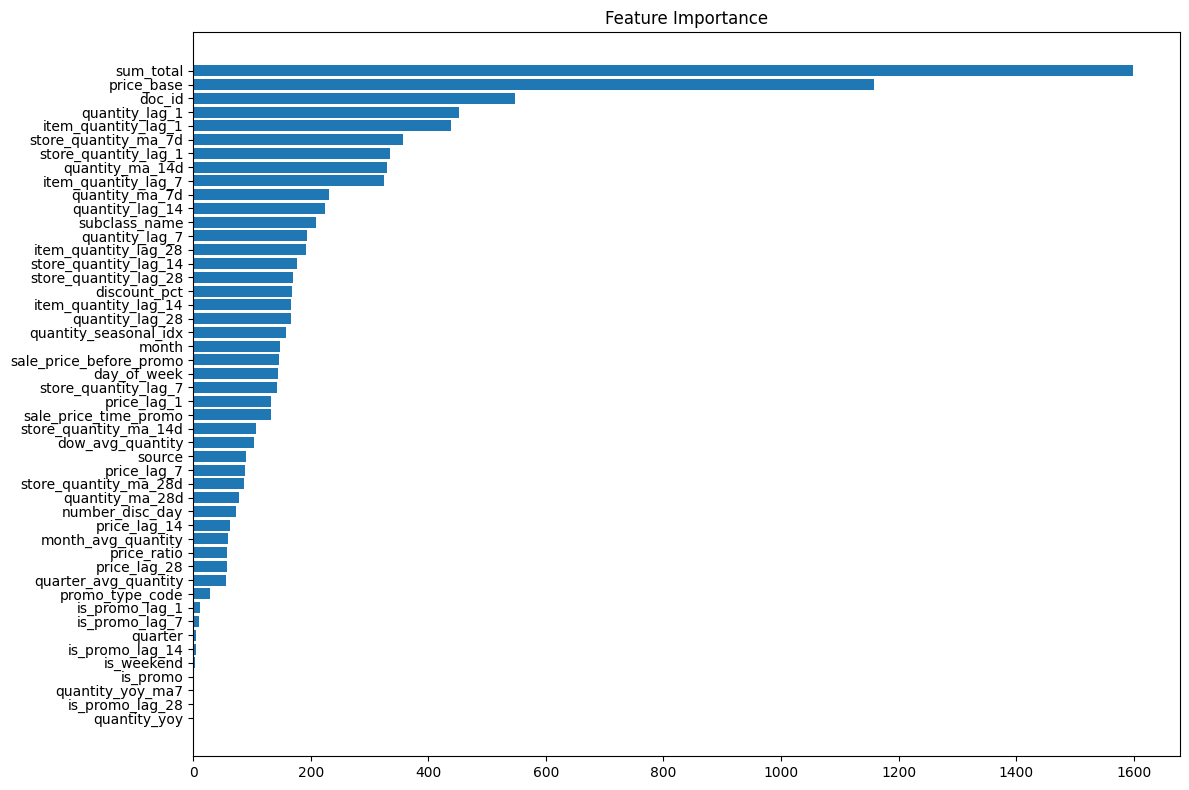

In [77]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from lightgbm import early_stopping, log_evaluation

# Assuming Final_data is your preprocessed dataframe from the previous code

# 1. Prepare the data
# Define the target variable and features
target_col = 'quantity'

# List of features to exclude from model training
exclude_cols = [
    'date', 'quantity', 'store_id', 'item_id', 'dept_name', 'class_name',
    'store_quantity', 'item_quantity', 'dept_quantity', 'class_quantity'
]

# Get feature columns
feature_cols = [col for col in Final_data.columns if col not in exclude_cols]

# Handle missing values in features
for col in feature_cols:
    if Final_data[col].dtype in ['int64','float64']:  # Only for numeric columns
        Final_data[col] = Final_data[col].fillna(Final_data[col].median())

# 2. Set up time-based validation
# Assuming your data is sorted by date
cutoff_date = Final_data['date'].max() - pd.Timedelta(days=28)  # Use last 28 days as validation
train_data = Final_data[Final_data['date'] <= cutoff_date]
valid_data = Final_data[Final_data['date'] > cutoff_date]

X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_valid = valid_data[feature_cols]
y_valid = valid_data[target_col]

# 3. Create LightGBM datasets
train_dataset = lgb.Dataset(X_train, label=y_train)
valid_dataset = lgb.Dataset(X_valid, label=y_valid, reference=train_dataset)

# 4. Set LightGBM parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}

# 5. Train the model - Fixing all API compatibility issues
# Try different training approaches based on LightGBM version

# Option 1: Use sklearn API which is more version-stable
from lightgbm import LGBMRegressor

model_sklearn = LGBMRegressor(
    objective='regression',
    metric='rmse',
    num_leaves=31,
    learning_rate=0.05,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    n_estimators=1000
)

# Fit with early stopping
model_sklearn.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='rmse',
    callbacks=[early_stopping(50), log_evaluation(50)]  # Controls verbosity
)


# Option 2: Basic train API that should work across versions
model = lgb.train(
    params,
    train_dataset,
    num_boost_round=1000,
    valid_sets=[train_dataset, valid_dataset]
)

# 6. Make predictions (using sklearn model)
y_pred = model_sklearn.predict(X_valid)

# 7. Evaluate model performance
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mae = mean_absolute_error(y_valid, y_pred)

print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation MAE: {mae:.4f}")

# 8. Feature importance analysis
plt.figure(figsize=(12, 8))
feature_importance = model_sklearn.feature_importances_
feature_names = model_sklearn.feature_name_

# Sort features by importance
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_cols[i] for i in sorted_idx])
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

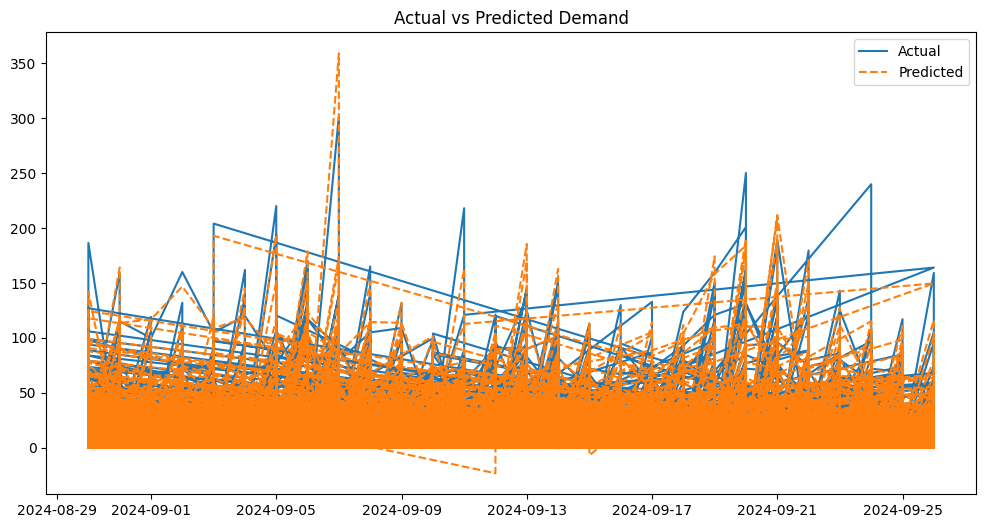

In [78]:
#Evaluating Time series Patterns
#Actual vs predicted values

plt.figure(figsize=(12, 6))
plt.plot(valid_data['date'], y_valid, label="Actual")
plt.plot(valid_data['date'], y_pred, label="Predicted", linestyle="dashed")
plt.legend()
plt.title("Actual vs Predicted Demand")
plt.show()


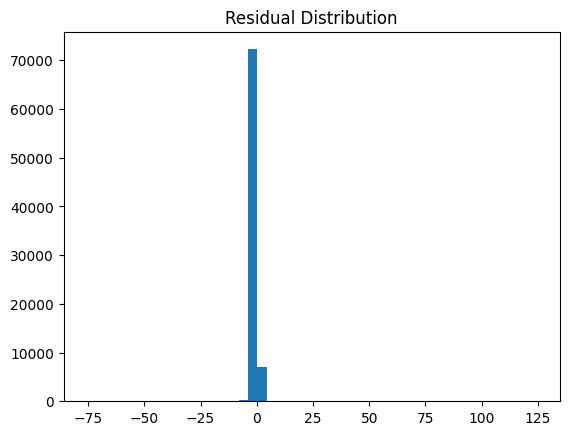

In [79]:
#Check Residuals (Errors should be normally distributed)

residuals = y_valid - y_pred
plt.hist(residuals, bins=50)
plt.title("Residual Distribution")
plt.show()

In [ ]:
#More optimization to smoothening to improve the prediction